In [1]:
# Jannik's models are not SAE Lens, so use Baukit
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "EleutherAI/pythia-70m"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
import os 
import sys
current_dir = "/root/GroupedSAEs/notebooks/circuits.ipynb"
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from huggingface_hub import hf_hub_download
from dictionary import GatedAutoEncoder

# Possible layers: 2,8,12,14,16,20
layer = 2
activation_names = [f"gpt_neox.layers.{layer}", f"gpt_neox.layers.{layer}.post_attention_layernorm"]
# activation_name = f"transformer.h.{layer}"

model_id = "jbrinkma/pythia-70m-saes"
normal_sae_name = f"Pythia-70M-L{layer}-Residual.pt"
skip_sae_name = f"Pythia-70M-L{layer}-SkipMLP.pt"
normal_ae_download_location = hf_hub_download(repo_id=model_id, filename=normal_sae_name)
skip_ae_download_location = hf_hub_download(repo_id=model_id, filename=skip_sae_name)
sae_res = GatedAutoEncoder.from_pretrained(normal_ae_download_location).to(device)
skip_sae = GatedAutoEncoder.from_pretrained(skip_ae_download_location).to(device)

In [3]:
from datasets import load_dataset
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

dataset_name = "stas/openwebtext-10k"
max_seq_length = 40
num_datapoints = 1000
total_tokens = max_seq_length * num_datapoints
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)

In [45]:
#set torch grad to zero globally
torch.set_grad_enabled(False)
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from baukit import TraceDict

batch_size = 64
# def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
num_features, d_model  = sae_res.encoder.weight.data.shape
datapoints = dataset.num_rows
dictionary_activations_res = torch.zeros((datapoints*max_seq_length, num_features))
dictionary_activations_skip = torch.zeros((datapoints*max_seq_length, num_features))
all_dictionary_activations = [dictionary_activations_res, dictionary_activations_skip]
token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)


residual_and_skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
residual_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)

feature_mse = torch.zeros(datapoints*max_seq_length)
feature_var_explained = torch.zeros(datapoints*max_seq_length)
with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.device)
        token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")

        # Grab intermediate activations
        with TraceDict(model, activation_names) as ret:
            _ = model(batch).logits
        for sae_ind, sae in enumerate([sae_res, skip_sae]):
            activations = ret[activation_names[sae_ind]].output
            # check if instance tuple
            if(isinstance(activations, tuple)):
                activations = activations[0]
                
            activations = rearrange(activations, "b s n -> (b s) n" )

            feature_acts = sae.encode(activations)
            all_dictionary_activations[sae_ind][batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = feature_acts.cpu()
            if sae_ind==0:
                reconstruction_residual = sae.decode(feature_acts)
                first_feature_mask = (feature_acts !=0).float()
                residual_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
            else:
                second_feature_mask = (feature_acts !=0).float()
                skip_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()

                # Calculate the correlation between the residual and skip activations
                residual_and_skip_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()


                # Check the MSE between the skip features & skip-features-w/-residual
                skip_feature_x_hat = skip_sae.encode(reconstruction_residual)
                skip_feature_mse = torch.mean((skip_feature_x_hat - feature_acts)**2, dim=-1)
                feature_act_var = torch.var(feature_acts)
                skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var
                feature_mse[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_mse.cpu()
                feature_var_explained[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_var_explained.cpu()

100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


In [275]:
# Calculate the Jaccard similarity between each feature
# nz_res_corr: matrix of co-occurrences
# residual_correlation: full residual correlation matrix
# nz_res_features: indices of non-zero features

# Total occurrences of each feature
total_occurrences = residual_correlation.diag()[nz_res_features][:, None]

# Co-occurrences
co_occurrences = nz_res_corr

# Union of occurrences
union_occurrences = total_occurrences + total_occurrences.T - co_occurrences

# Jaccard similarity
jacc_sim_res_dim0_original = co_occurrences / union_occurrences
jacc_sim_res_dim0_original.fill_diagonal_(0)

jacc_sim_res_dim0_original = jaccard_similarity(nz_res_corr, residual_correlation.diag()[nz_res_features][:, None])
jacc_sim_res_dim0_original[:10, :10]

tensor([[0.0000, 0.0011, 0.0000, 0.0032, 0.0000, 0.0044, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0011, 0.0000, 0.0035, 0.0311, 0.0006, 0.0011, 0.0000, 0.0011, 0.0000,
         0.0022],
        [0.0000, 0.0035, 0.0000, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0032, 0.0311, 0.0020, 0.0000, 0.0000, 0.0048, 0.0000, 0.0005, 0.0009,
         0.0023],
        [0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0597, 0.0000,
         0.0000],
        [0.0044, 0.0011, 0.0000, 0.0048, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0011, 0.0000, 0.0005, 0.0597, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0009, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0022, 0.0000, 0.0023, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

In [280]:
nz_res_skip_corr
total_occurrences_res = resid_diag[nz_res_features][:, None]
total_occurrences_skip = skip_diag[nz_skip_features][:, None]
total_occurrences = total_occurrences_res + total_occurrences_skip.T
total_occurrences.shape, nz_res_skip_corr.shape

(torch.Size([4172, 3600]), torch.Size([4172, 3600]))

In [292]:
# I need a specific set of information for each node.
'''
0. Remove features that activate < 10 times
1. Each input's jaccard sim
2. Each output's jaccard sim
3. Eachl input's jaccard sim to each output
3.2 Weight similarity of input-to-output
4. Each nz_features top-5 common tokens
'''

def jaccard_similarity(co_occurrences, total_occurrences_1, total_occurrences_2):
    # Union of occurrences
    union_occurrences = total_occurrences_1 + total_occurrences_2.T - co_occurrences
    # Jaccard similarity
    jacc_sim = co_occurrences / union_occurrences
    return jacc_sim

# Remove features that activate < 10 times
activation_threshold = 10
frequency_threshold = 0.1

# Residual features
resid_diag = residual_correlation.diag()
nz_res_features = resid_diag >  activation_threshold
# Also remove high frequency features
res_freq = resid_diag / total_tokens
nz_res_features = nz_res_features & (res_freq < frequency_threshold)
nz_res_corr = residual_correlation[nz_res_features][:, nz_res_features]

# Repeat for skip
skip_diag = skip_correlation.diag()
nz_skip_features = skip_diag > activation_threshold
skip_freq = skip_diag / total_tokens
nz_skip_features = nz_skip_features & (skip_freq < frequency_threshold)
nz_skip_corr = skip_correlation[nz_skip_features][:, nz_skip_features]

# Repeat for residual to skip
nz_res_skip_corr = residual_and_skip_correlation[nz_res_features][:, nz_skip_features]

# Calculate the jaccard similarity between each feature
total_occur_res = resid_diag[nz_res_features][:, None]
total_occur_skip = skip_diag[nz_skip_features][:, None]
jacc_sim_res_dim0_original = jaccard_similarity(total_occurrences_1 = total_occur_res, total_occurrences_2 = total_occur_res, co_occurrences = nz_res_corr)
jacc_sim_skip_dim0_original = jaccard_similarity(total_occurrences_1 = total_occur_skip, total_occurrences_2 = total_occur_skip, co_occurrences = nz_skip_corr)
jacc_sim_res_to_skip_original = jaccard_similarity(total_occurrences_1 = total_occur_res, total_occurrences_2 = total_occur_skip, co_occurrences = nz_res_skip_corr)

# save the jaccard diag
# save the diagonals
jacc_res_diag = jacc_sim_res_dim0_original.diag()
jacc_skip_diag = jacc_sim_skip_dim0_original.diag()

# set the diagonal to zero
jacc_sim_res_dim0_original.fill_diagonal_(0)
jacc_sim_skip_dim0_original.fill_diagonal_(0)

# Find index of features above a correlation threshold
correlation_threshold = 0.3
# Set upper triangle to lower triangle
res_index_above_corr = (jacc_sim_res_dim0_original > correlation_threshold).sum(0).nonzero()[:, 0]
skip_index_above_corr = (jacc_sim_skip_dim0_original > correlation_threshold).sum(0).nonzero()[:, 0]
extra_res_nodes = (jacc_sim_res_to_skip_original > correlation_threshold).sum(1).nonzero()[:, 0]
extra_skip_nodes = (jacc_sim_res_to_skip_original > correlation_threshold).sum(0).nonzero()[:, 0]

# index into the above features
jacc_sim_res_dim0 = jacc_sim_res_dim0_original[res_index_above_corr][:, res_index_above_corr]
jacc_sim_skip_dim0 = jacc_sim_skip_dim0_original[skip_index_above_corr][:, skip_index_above_corr]
jacc_sim_res_to_skip = jacc_sim_res_to_skip_original[extra_res_nodes][:, extra_skip_nodes]

nz_res_ind = nz_res_features.nonzero()[:, 0]
combined_res_ind = torch.tensor(list(set(res_index_above_corr.tolist() + extra_res_nodes.tolist())))
global_id_res_group = nz_res_ind[combined_res_ind]
res_only_global_id = nz_res_ind[res_index_above_corr]
cross_connection_res_global_id = nz_res_ind[extra_res_nodes]

# skip
nz_skip_ind = nz_skip_features.nonzero()[:, 0]
combined_skip_ind = torch.tensor(list(set(skip_index_above_corr.tolist() + extra_skip_nodes.tolist())))
global_id_skip_group = nz_skip_ind[combined_skip_ind]
skip_only_global_id = nz_skip_ind[skip_index_above_corr]
cross_connection_skip_global_id = nz_skip_ind[extra_skip_nodes]
print(f"number of res nodes {len(global_id_res_group)}")
print(f"number of skip nodes {len(global_id_skip_group)}")

number of res nodes 518
number of skip nodes 662


In [311]:
from collections import Counter

# nz_dict_act_res is size (tokens, features)

# For each feature, get the top-5 tokens by occurance
def get_top_tokens(dictionary_activations, token_list, tokenizer):
    feature_labels = []
    feature_hovertips = []
    for feature in tqdm(dictionary_activations.T):
        nz_feature_ind = feature != 0
        total_nz = nz_feature_ind.sum()
        specific_tokens = token_list[nz_feature_ind].numpy()
        counter = Counter(specific_tokens).most_common(5)
        hovertip_str = ""
        for token_loop_ind, (token, count) in enumerate(counter):
            token_str = tokenizer.decode(token)
            percentage = count / total_nz
            token_str = token_str.replace("\n", "\\n").replace(" ", "_")
            # token_str = token_str.replace("Ġ", "_")
            hovertip_str += f"{token_str}: {percentage:.0%}"
            if(token_loop_ind == 0):
                feature_labels.append(token_str)
        feature_hovertips.append(hovertip_str)
    # replace \n w/ \\newline
    # feature_hovertips = [hovertip.replace("\n", "\\n") for hovertip in feature_hovertips]
    # feature_labels = [label.replace("\n", "\\n") for label in feature_labels]
    # replace 'Ġ' w/ _
    # feature_hovertips = [hovertip.replace("Ġ", "_") for hovertip in feature_hovertips]
    # feature_labels = [label.replace("Ġ", "_") for label in feature_labels]


    return feature_labels, feature_hovertips

# Get the top-5 tokens for each feature
# token_list, dictionary_activations_res, dictionary_activations_skip
nz_dict_act_res = dictionary_activations_res[:, global_id_res_group].numpy()
nz_dict_act_skip = dictionary_activations_skip[:, global_id_skip_group].numpy()

res_feature_labels, res_feature_hovertips = get_top_tokens(nz_dict_act_res, token_list, tokenizer)
skip_feature_labels, skip_feature_hovertips = get_top_tokens(nz_dict_act_skip, token_list, tokenizer)

100%|██████████| 662/662 [00:04<00:00, 135.00it/s]


In [299]:
# TODO change display corre threshold
# TODO: check if triu-> tril fixes things
# alt, just allow duplicates (by erasing diagonal?)
def get_connection_weights(jacc_sim, global_id_x, global_id_y, display_correlation_threshold=0.2):
    row, col = (jacc_sim > display_correlation_threshold).nonzero().T
    weight = jacc_sim[row, col]
    row = global_id_x[row]
    col = global_id_y[col]
    return [[row[i].item(), col[i].item(), weight[i].item()] for i in range(len(row))]

res_connections = get_connection_weights(jacc_sim_res_dim0, res_only_global_id, res_only_global_id)
skip_connections = get_connection_weights(jacc_sim_skip_dim0, skip_only_global_id, skip_only_global_id)
cross_connections = get_connection_weights(jacc_sim_res_to_skip, cross_connection_res_global_id, cross_connection_skip_global_id)
print(f"Res Connections: {len(res_connections)}")
print(f"Skip Connections: {len(skip_connections)}")
print(f"Cross Connections: {len(cross_connections)}")

Res Connections: 292
Skip Connections: 904
Cross Connections: 1082


In [315]:
import json

# Generate HTML content with correct variable substitution
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        body, html {{
            margin: 0;
            height: 100%;
            overflow: hidden;
        }}
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .tooltip {{
            position: absolute;
            text-align: center;
            width: auto;
            height: auto;
            padding: 5px;
            font: 12px sans-serif;
            background: lightsteelblue;
            border: 0px;
            border-radius: 8px;
            pointer-events: none;
            opacity: 0;
            transition: opacity 0.3s;
        }}
        .zoomable {{
            cursor: grab;
        }}
    </style>
</head>
<body>
    <svg width="100%" height="100%" class="zoomable"></svg>
    <script>
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};

        const resFeatureHovertips = {res_feature_hovertips};
        const skipFeatureHovertips = {skip_feature_hovertips};

        const resGlobalID = {res_global_id};
        const skipGlobalID = {skip_global_id};

        const res_connections = {res_connections};
        const skip_connections = {skip_connections};
        const cross_connections = {cross_connections};

        const nodes = [];

        resGlobalID.forEach((global_id, i) => {{
            const full_id_name = `res_${{global_id}}`;
            nodes.push({{ id: full_id_name, group: 'res', color: 'blue', defaultLabel: resFeatureLabels[i], hoverLabel: resFeatureHovertips[i]+ full_id_name}});
        }});

        skipGlobalID.forEach((global_id, i) => {{
            const full_id_name = `skip_${{global_id}}`;
            nodes.push({{ id: full_id_name, group: 'skip', color: 'red', defaultLabel: skipFeatureLabels[i], hoverLabel: skipFeatureHovertips[i]+full_id_name }});
        }});


        const links = [];
        res_connections.forEach(([res_ind_x, res_ind_y, weight]) => {{
            const source = `res_${{res_ind_x}}`;
            const target = `res_${{res_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'blue' }});
        }});

        skip_connections.forEach(([skip_ind_x, skip_ind_y, weight]) => {{
            const source = `skip_${{skip_ind_x}}`;
            const target = `skip_${{skip_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'red' }});
        }});

        cross_connections.forEach(([res_ind_x, skip_ind_y, weight]) => {{
            const source = `res_${{res_ind_x}}`;
            const target = `skip_${{skip_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'purple' }});
        }});

        const svg = d3.select("svg"),
            width = window.innerWidth,
            height = window.innerHeight;

        const tooltip = d3.select("body").append("div")
            .attr("class", "tooltip");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-30))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("x", d3.forceX(width / 2).strength(0.07))
            .force("y", d3.forceY(height / 2).strength(0.07));

        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", (event, d) => {{
                tooltip.transition().duration(200).style("opacity", 0.9);
                tooltip.html(d.hoverLabel)
                    .style("left", (event.pageX + 5) + "px")
                    .style("top", (event.pageY - 28) + "px");
            }})
            .on("mouseout", () => {{
                tooltip.transition().duration(500).style("opacity", 0);
            }});

        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        svg.call(d3.zoom().on("zoom", (event) => {{
            svg.attr("transform", event.transform);
        }}));

        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=json.dumps(res_feature_labels),
    skip_feature_labels=json.dumps(skip_feature_labels),
    res_feature_hovertips=json.dumps(res_feature_hovertips),
    skip_feature_hovertips=json.dumps(skip_feature_hovertips),
    res_global_id=json.dumps(global_id_res_group.tolist()),
    skip_global_id=json.dumps(global_id_skip_group.tolist()),
    res_connections=json.dumps(res_connections),
    skip_connections=json.dumps(skip_connections),
    cross_connections=json.dumps(cross_connections),
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)


In [16]:
import json
import torch

# Commented out example data, assume these are defined earlier
# jacc_sim_res_dim0 = torch.load('path_to_res_dim0_tensor.pt')  # Replace with your actual tensor path
# jacc_sim_skip_dim0 = torch.load('path_to_skip_dim0_tensor.pt')  # Replace with your actual tensor path
# jacc_sim_res_to_skip = torch.load('path_to_res_to_skip_tensor.pt')  # Replace with your actual tensor path

# # Set a threshold for filtering weak connections
# threshold = 0.8

# def filter_connections(matrix, threshold):
#     indices = torch.nonzero(matrix >= threshold, as_tuple=False)
#     filtered_connections = []
#     for i in range(matrix.size(0)):
#         connections = [[j.item(), matrix[i, j].item()] for j in indices[indices[:, 0] == i][:, 1]]
#         filtered_connections.append(connections)
#     return filtered_connections

# filtered_within_res = filter_connections(jacc_sim_res_dim0, threshold)
# filtered_within_skip = filter_connections(jacc_sim_skip_dim0, threshold)
# filtered_res_to_skip = filter_connections(jacc_sim_res_to_skip, threshold)

# def get_connected_nodes(filtered_connections):
#     connected_nodes = set()
#     for i, connections in enumerate(filtered_connections):
#         if connections:
#             connected_nodes.add(i)
#             for j, _ in connections:
#                 connected_nodes.add(j)
#     return connected_nodes

# connected_res_nodes = get_connected_nodes(filtered_within_res)
# connected_skip_nodes = get_connected_nodes(filtered_within_skip)
# connected_res_to_skip_nodes = set()
# for i, connections in enumerate(filtered_res_to_skip):
#     if connections:
#         connected_res_to_skip_nodes.add(i)
#         for j, _ in connections:
#             connected_skip_nodes.add(j)

# connected_res_nodes = connected_res_nodes.union(connected_res_to_skip_nodes)

# Derive shapes from the tensor sizes
# res_feature_labels = ["Res_Feature_" + str(i) for i in range(jacc_sim_res_dim0.size(0)) if i in connected_res_nodes]
# skip_feature_labels = ["Skip_Feature_" + str(i) for i in range(jacc_sim_skip_dim0.size(0)) if i in connected_skip_nodes]
# res_feature_hovertips = ["Res_Hover_" + str(i) for i in range(jacc_sim_res_dim0.size(0)) if i in connected_res_nodes]
# skip_feature_hovertips = ["Skip_Hover_" + str(i) for i in range(jacc_sim_skip_dim0.size(0)) if i in connected_skip_nodes]

# Generate HTML content with correct variable substitution
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        body, html {{
            margin: 0;
            height: 100%;
            overflow: hidden;
        }}
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
            background-color: white;
            padding: 2px;
            border-radius: 2px;
        }}
        .zoomable {{
            cursor: grab;
        }}
    </style>
</head>
<body>
    <svg width="100%" height="100%" class="zoomable"></svg>
    <script>
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};
        const resFeatureHovertips = {res_feature_hovertips};
        const skipFeatureHovertips = {skip_feature_hovertips};
        const withinResCorrelation = {within_res_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const resSkipCorrelation = {res_skip_correlation};

        const nodes = [];
        const nodeIdMap = new Map();

        resFeatureLabels.forEach((label, i) => {{
            const nodeId = `res_${{i}}`;
            nodes.push({{ id: nodeId, group: 'res', color: 'blue', defaultLabel: label, hoverLabel: resFeatureHovertips[i] }});
            nodeIdMap.set(i, nodeId);
        }});

        skipFeatureLabels.forEach((label, i) => {{
            const nodeId = `skip_${{i}}`;
            nodes.push({{ id: nodeId, group: 'skip', color: 'red', defaultLabel: label, hoverLabel: skipFeatureHovertips[i] }});
            nodeIdMap.set(i, nodeId);
        }});

        const links = [];
        withinResCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j);
                links.push({{ source: source, target: target, value: value, color: 'blue' }});
            }});
        }});

        withinSkipCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j);
                links.push({{ source: source, target: target, value: value, color: 'red' }});
            }});
        }});

        resSkipCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j + resFeatureLabels.length);
                links.push({{ source: source, target: target, value: value, color: 'green' }});
            }});
        }});

        const svg = d3.select("svg"),
            width = window.innerWidth,
            height = window.innerHeight;

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-30))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("x", d3.forceX(width / 2).strength(0.1))
            .force("y", d3.forceY(height / 2).strength(0.1));

        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        svg.call(d3.zoom().on("zoom", (event) => {{
            svg.attr("transform", event.transform);
        }}));

        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=json.dumps(res_feature_labels),
    skip_feature_labels=json.dumps(skip_feature_labels),
    res_feature_hovertips=json.dumps(res_feature_hovertips),
    skip_feature_hovertips=json.dumps(skip_feature_hovertips),
    within_res_correlation=json.dumps(filtered_within_res),
    within_skip_correlation=json.dumps(filtered_within_skip),
    res_skip_correlation=json.dumps(filtered_res_to_skip)
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)


In [102]:
filtered_within_res[0]

[(2539, 0.5762711763381958), (3130, 1.0)]

In [ ]:
import torch

# Your actual data should be assigned to these variables
# res_feature_labels = [...]  # Replace with your actual data
# skip_feature_labels = [...]  # Replace with your actual data
# jacc_sim_res_dim0 = torch.tensor([...])  # Replace with your actual tensor
# jacc_sim_skip_dim0 = torch.tensor([...])  # Replace with your actual tensor
# jacc_sim_res_to_skip = torch.tensor([...])  # Replace with your actual tensor

# Set a threshold for filtering weak connections
threshold = 0.1

def filter_connections(matrix, threshold):
    filtered_connections = []
    for i in tqdm(range(matrix.size(0))):
        connections = []
        for j in range(matrix.size(1)):
            if matrix[i, j] >= threshold:
                connections.append((j, matrix[i, j].item()))
        filtered_connections.append(connections)
    return filtered_connections

# Filter the matrices based on the threshold
filtered_within_res = filter_connections(jacc_sim_res_dim0, threshold)
filtered_within_skip = filter_connections(jacc_sim_skip_dim0, threshold)
filtered_res_to_skip = filter_connections(jacc_sim_res_to_skip, threshold)

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
        }}
    </style>
</head>
<body>
    <svg width="1600" height="900"></svg>
    <script>
        // Data for the graph
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};
        const withinResCorrelation = {within_res_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const resSkipCorrelation = {res_skip_correlation};

        // Create nodes
        const nodes = [];
        for (let i = 0; i < resFeatureLabels.length; i++) {{
            nodes.push({{ id: `res_${{i}}`, group: 'res', color: 'blue', defaultLabel: resFeatureLabels[i], hoverLabel: `Hover info for {{resFeatureLabels[i]}}` }});
        }}
        for (let i = 0; i < skipFeatureLabels.length; i++) {{
            nodes.push({{ id: `skip_${{i}}`, group: 'skip', color: 'red', defaultLabel: skipFeatureLabels[i], hoverLabel: `Hover info for {{skipFeatureLabels[i]}}` }});
        }}

        // Create links (only for non-zero weights)
        const links = [];
        withinResCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `res_${{i}}`, target: `res_${{j}}`, value: value, color: 'blue' }});
            }});
        }});
        withinSkipCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `skip_${{i}}`, target: `skip_${{j}}`, value: value, color: 'red' }});
            }});
        }});
        resSkipCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `res_${{i}}`, target: `skip_${{j}}`, value: value, color: 'green' }});
            }});
        }});

        // Set up SVG and simulation
        const svg = d3.select("svg"),
            width = +svg.attr("width"),
            height = +svg.attr("height");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(d => Math.exp(-d.value)))
            .force("charge", d3.forceManyBody().strength(-500))
            .force("center", d3.forceCenter(width / 2, height / 2));

        // Add links
        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        // Add nodes
        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        // Add visible labels
        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        // Add hover labels
        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        // Update simulation on each tick
        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        // Drag functions
        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=res_feature_labels,
    skip_feature_labels=skip_feature_labels,
    within_res_correlation=filtered_within_res,
    within_skip_correlation=filtered_within_skip,
    res_skip_correlation=filtered_res_to_skip
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)


In [ ]:
filtered_within_res

In [92]:
for threshold in [0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f" {(jacc_sim_skip_dim0 > threshold).sum()} connections above {threshold}")
    print(f" {(jacc_sim_res_dim0 > threshold).sum()} connections above {threshold}")
    print(f" {(jacc_sim_res_to_skip > threshold).sum()} connections above {threshold}")
    print("------------------------------------------------------------")

 2020103 connections above 0.01
 1856736 connections above 0.01
 2166155 connections above 0.01
------------------------------------------------------------
 982590 connections above 0.05
 590663 connections above 0.05
 1078060 connections above 0.05
------------------------------------------------------------
 395397 connections above 0.1
 228890 connections above 0.1
 467454 connections above 0.1
------------------------------------------------------------
 107448 connections above 0.2
 55632 connections above 0.2
 116926 connections above 0.2
------------------------------------------------------------
 47336 connections above 0.3
 20386 connections above 0.3
 43322 connections above 0.3
------------------------------------------------------------
 25744 connections above 0.4
 9977 connections above 0.4
 21734 connections above 0.4
------------------------------------------------------------
 15718 connections above 0.5
 6015 connections above 0.5
 13693 connections above 0.5
------

In [9]:
import torch

# Example data
num_features = 5
within_res_correlation = torch.randn(num_features, num_features).tolist()
res_skip_correlation = torch.randn(num_features, num_features).tolist()
within_skip_correlation = torch.randn(num_features, num_features).tolist()
default_labels = [f'Feature_{i}' for i in range(num_features)]
hover_labels = [f'Hover info for Feature_{i}' for i in range(num_features)]

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
        }}
    </style>
</head>
<body>
    <svg width="960" height="600"></svg>
    <script>
        // Data for the graph
        const numFeatures = {num_features};
        const withinResCorrelation = {within_res_correlation};
        const resSkipCorrelation = {res_skip_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const defaultLabels = {default_labels};
        const hoverLabels = {hover_labels};

        // Create nodes
        const nodes = [];
        for (let i = 0; i < numFeatures; i++) {{
            nodes.push({{ id: `res_${{i}}`, group: 'res', color: 'blue', defaultLabel: defaultLabels[i], hoverLabel: hoverLabels[i] }});
            nodes.push({{ id: `skip_${{i}}`, group: 'skip', color: 'red', defaultLabel: defaultLabels[i], hoverLabel: hoverLabels[i] }});
        }}

        // Create links
        const links = [];
        for (let i = 0; i < numFeatures; i++) {{
            for (let j = 0; j < numFeatures; j++) {{
                if (i !== j) {{
                    links.push({{ source: `res_${{i}}`, target: `res_${{j}}`, value: withinResCorrelation[i][j], color: 'blue' }});
                    links.push({{ source: `skip_${{i}}`, target: `skip_${{j}}`, value: withinSkipCorrelation[i][j], color: 'red' }});
                }}
                links.push({{ source: `res_${{i}}`, target: `skip_${{j}}`, value: resSkipCorrelation[i][j], color: 'green' }});
            }}
        }}

        // Set up SVG and simulation
        const svg = d3.select("svg"),
            width = +svg.attr("width"),
            height = +svg.attr("height");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-400))
            .force("center", d3.forceCenter(width / 2, height / 2));

        // Add links
        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(d.value))
            .attr("stroke", d => d.color);

        // Add nodes
        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 10)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        // Add visible labels
        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        // Add hover labels
        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        // Update simulation on each tick
        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        // Drag functions
        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    num_features=num_features,
    within_res_correlation=within_res_correlation,
    res_skip_correlation=res_skip_correlation,
    within_skip_correlation=within_skip_correlation,
    default_labels=default_labels,
    hover_labels=hover_labels
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)

In [5]:
# Okay, now let's just naively multiply the decoder weight by the encoder weight
res_dec = sae_res.decoder.weight.data
skip_enc = skip_sae.encoder.weight.data
combined = skip_enc @ res_dec
# res_dec = sae_res.encoder.weight.data
# skip_dec = skip_sae.decoder.weight.data
# combined = res_dec@ skip_dec
combined.shape

torch.Size([8192, 8192])

In [6]:
# w_writing -= W_writing.mean(dim=1, keepdim=True)

In [16]:
# I'd like to fold in layer norm
ln_mlp = model.gpt_neox.layers[layer].post_attention_layernorm
# 1. center the weights that write into res
centered_decoder = res_dec - res_dec.mean(dim=1, keepdim=True)
# 2. Add in layer norm weight to the read in weight
ln_w = ln_mlp.weight.data
ln_b = ln_mlp.bias.data

# Get weights and biases of the next linear layer
W = skip_sae.encoder.weight.data.T  # The next linear layer weights
# B = skip_sae.mag_bias.data  # The next linear layer biases
B = skip_sae.gate_bias.data  # The next linear layer biases

# Calculate W_eff and B_eff
W_eff = torch.diag(ln_w) @ W
B_eff = B + ln_b @ W

# Centering the reading weights
W_eff -= W_eff.mean(dim=0, keepdim=True)

In [12]:
centered_decoder.shape, W_eff.shape

(torch.Size([512, 8192]), torch.Size([512, 8192]))

In [17]:
ln_mlp = model.gpt_neox.layers[2].post_attention_layernorm

for d_point_ind in range(1,20):
    print(f"Data Point {d_point_ind}")
    f1 = dictionary_activations_res[d_point_ind].to(device)
    f2 = dictionary_activations_skip[d_point_ind].to(device)
    f2_hat = torch.clamp(combined @ f1, min=0)
    test_f2 = torch.clamp(skip_enc @ ln_mlp(res_dec@f1), min=0)
    new_f2 = torch.clamp(skip_sae.encode(ln_mlp(sae_res.decode(f1))), min=0)
    fold_in_test = torch.clamp((W_eff.T @ centered_decoder @ f1) + B_eff, min=0) 
    print(torch.allclose(test_f2, f2_hat, atol=1e-5))
    top_ind = f2.topk(5).indices
    # for ind in top_ind:
    #     print(f"{fold_in_test[ind]:.2f}, {test_f2[ind]:.2f}, {f2[ind]:.2f}")
    mse = torch.mean((f2[top_ind] - new_f2[top_ind])**2)
    mse_ln = torch.mean((f2[top_ind] - test_f2[top_ind])**2)
    print(f"fold_in_test: {mse:.2f}, MSE LN: {mse_ln:.2f}")

Data Point 1
False
fold_in_test: 0.53, MSE LN: 0.42
Data Point 2
False
fold_in_test: 0.22, MSE LN: 0.26
Data Point 3
False
fold_in_test: 0.49, MSE LN: 0.51
Data Point 4
False
fold_in_test: 0.78, MSE LN: 0.66
Data Point 5
False
fold_in_test: 0.48, MSE LN: 0.25
Data Point 6
False
fold_in_test: 0.48, MSE LN: 0.54
Data Point 7
False
fold_in_test: 0.60, MSE LN: 0.70
Data Point 8
False
fold_in_test: 0.36, MSE LN: 0.35
Data Point 9
False
fold_in_test: 0.40, MSE LN: 0.34
Data Point 10
False
fold_in_test: 0.93, MSE LN: 0.68
Data Point 11
False
fold_in_test: 0.92, MSE LN: 0.88
Data Point 12
False
fold_in_test: 0.36, MSE LN: 0.32
Data Point 13
False
fold_in_test: 0.93, MSE LN: 0.94
Data Point 14
False
fold_in_test: 0.98, MSE LN: 1.08
Data Point 15
False
fold_in_test: 0.81, MSE LN: 0.87
Data Point 16
False
fold_in_test: 0.34, MSE LN: 0.38
Data Point 17
False
fold_in_test: 0.44, MSE LN: 0.71
Data Point 18
False
fold_in_test: 2.45, MSE LN: 2.28
Data Point 19
False
fold_in_test: 0.47, MSE LN: 0.49


In [131]:
ln_mlp = model.gpt_neox.layers[2].post_attention_layernorm

for d_point_ind in range(20):
    print(f"Data Point {d_point_ind}")
    f1 = dictionary_activations_res[d_point_ind].to(device)
    f2 = dictionary_activations_skip[d_point_ind].to(device)
    f2_hat = combined @ f1
    test_f2 = skip_enc@ ln_mlp(res_dec@f1)
    print(torch.allclose(test_f2, f2_hat, atol=1e-5))
    top_ind = f2.topk(15).indices
    for ind in top_ind:
        print(f"{f2_hat[ind]:.2f}, {test_f2[ind]:.2f}, {f2[ind]:.2f}")

Data Point 0
False
19.93, 4.91, 18.92
7.09, 1.42, 4.08
5.26, 1.19, 2.86
5.00, 1.00, 2.73
4.04, 0.76, 2.53
3.57, 0.69, 2.49
4.49, 0.83, 2.47
4.04, 0.82, 2.46
3.16, 0.65, 2.27
3.43, 0.46, 2.26
3.73, 0.68, 2.26
3.67, 0.78, 2.06
3.16, 0.66, 1.88
3.16, 0.62, 1.87
3.45, 0.52, 1.82
Data Point 1
False
-12.38, -38.03, 2.54
1.54, 4.47, 1.85
-0.70, -3.41, 0.76
0.08, 0.11, 0.26
-0.45, -1.92, 0.24
-0.89, -3.04, 0.21
0.22, 0.24, 0.21
0.85, 1.73, 0.20
0.46, 0.84, 0.20
0.34, 0.13, 0.19
0.18, 0.20, 0.19
0.33, 0.59, 0.17
0.36, 0.59, 0.17
0.35, 0.56, 0.17
0.42, 0.77, 0.17
Data Point 2
False
1.35, 4.18, 1.89
0.13, 0.07, 0.30
0.14, 0.28, 0.27
0.15, -0.02, 0.24
-0.06, -0.07, 0.22
0.14, 0.39, 0.19
0.00, 0.12, 0.19
0.20, 0.31, 0.19
-0.07, -0.31, 0.18
0.42, 0.65, 0.18
0.19, 0.38, 0.18
0.20, 0.26, 0.17
0.16, 0.21, 0.17
0.19, 0.28, 0.16
0.21, 0.45, 0.15
Data Point 3
False
-9.75, -32.72, 3.05
1.00, 3.33, 1.38
-0.02, -1.41, 0.87
0.39, 0.76, 0.58
0.44, 0.75, 0.45
0.26, 0.01, 0.41
0.28, 0.41, 0.32
-0.48, -1.96, 0.27

In [124]:
f2.topk(100)

torch.return_types.topk(
values=tensor([18.9184,  4.0784,  2.8593,  2.7319,  2.5296,  2.4910,  2.4732,  2.4591,
         2.2727,  2.2623,  2.2605,  2.0583,  1.8783,  1.8740,  1.8242,  1.8031,
         1.7778,  1.7658,  1.7558,  1.7549,  1.7464,  1.7331,  1.7292,  1.7254,
         1.6944,  1.6513,  1.6329,  1.6224,  1.6099,  1.6048,  1.5902,  1.5876,
         1.5840,  1.5729,  1.5443,  1.5320,  1.5310,  1.5199,  1.5186,  1.5115,
         1.4694,  1.4676,  1.4634,  1.4531,  1.4170,  1.3952,  1.3948,  1.3786,
         1.3783,  1.3693,  1.3407,  1.3399,  1.3214,  1.2816,  1.2780,  1.2769,
         1.2681,  1.2581,  1.2279,  1.2220,  1.2199,  1.2103,  1.1947,  1.1850,
         1.1832,  1.1656,  1.1646,  1.1210,  1.1034,  1.1017,  1.0879,  1.0501,
         1.0356,  1.0296,  0.9993,  0.9948,  0.9869,  0.9855,  0.9817,  0.9657,
         0.9584,  0.9549,  0.9480,  0.9450,  0.9389,  0.9286,  0.9277,  0.9241,
         0.9195,  0.9180,  0.9137,  0.9105,  0.9043,  0.8979,  0.8928,  0.8752,
        

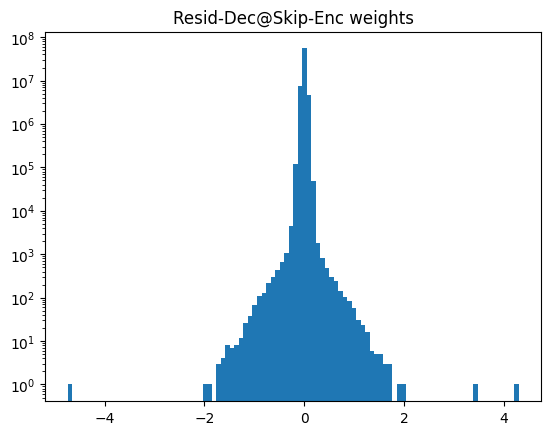

In [97]:
# plot the dist of the combined weights
import matplotlib.pyplot as plt
plt.hist(combined.flatten().cpu().numpy(), bins=100)
# y ax log
plt.title("Resid-Dec@Skip-Enc weights")
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [78]:
combined.max(0).values.topk(10), combined.min(0).values.topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([4.2925, 1.7148, 1.2443, 0.6057, 0.4973, 0.4901, 0.4660, 0.4499, 0.3807,
         0.3700], device='cuda:0'),
 indices=tensor([1477, 5432, 2995, 7856, 7523, 5225, 1493, 5216, 2743, 5933],
        device='cuda:0')),
 torch.return_types.topk(
 values=tensor([-4.7403, -1.7134, -0.6850, -0.5077, -0.4975, -0.4813, -0.4678, -0.3732,
         -0.3674, -0.3619], device='cuda:0'),
 indices=tensor([1477, 5432, 5225, 2995, 6262, 2743, 7523, 8154, 2448, 3895],
        device='cuda:0')))

In [82]:
dictionary_activations_res[:1000].max(0).values.topk(10), dictionary_activations_skip[:1000].max(0).values.topk(10)

(torch.return_types.topk(
 values=tensor([125.2061, 105.0183,  25.0771,   8.0769,   8.0200,   7.4735,   7.1577,
           7.1127,   6.5055,   6.4784]),
 indices=tensor([5224, 6097, 7759, 6353, 2645, 7478, 3580, 1000, 7052,  261])),
 torch.return_types.topk(
 values=tensor([55.4205, 27.9668,  7.3213,  7.2092,  5.2458,  4.8454,  4.8416,  4.3618,
          4.1407,  3.7042]),
 indices=tensor([1477, 7383, 1445, 5432, 1837, 3313, 3054,  174, 1283, 3736])))

In [ ]:
# Create two random res_dec-shaped matrix, and combine them like above
import torch.nn.functional as F
res_dec_rand = F.normalize(torch.randn_like(res_dec), dim=-1)

In [58]:
x_hat = feature_acts
x_hat_prime = skip_feature_x_hat
# Step 1: Compute the mean of x_hat_prime along the batch dimension
x_hat_prime_mean = torch.mean(x_hat_prime, dim=0)

# Step 2: Calculate SS_tot (total sum of squares) for each feature
ss_tot = torch.sum((x_hat_prime - x_hat_prime_mean) ** 2, dim=-1)

# Step 3: Calculate SS_res (residual sum of squares) for each feature
ss_res = torch.sum((x_hat_prime - x_hat) ** 2, dim=-1)
r2 = 1 - (ss_res / ss_tot)
# set nans to 0
# r2[torch.isnan(r2)] = 0
r2

tensor([0.9936, 0.9938, 0.9769,  ..., 0.7565, 0.6615, 0.7212], device='cuda:0')

In [48]:
ss_tot[:3], ss_res[:3], r2[:3]

(tensor([1.2240, 0.0000, 0.4828], device='cuda:0'),
 tensor([1.1337, 0.0000, 0.4043], device='cuda:0'),
 tensor([0.0737,    nan, 0.1626], device='cuda:0'))

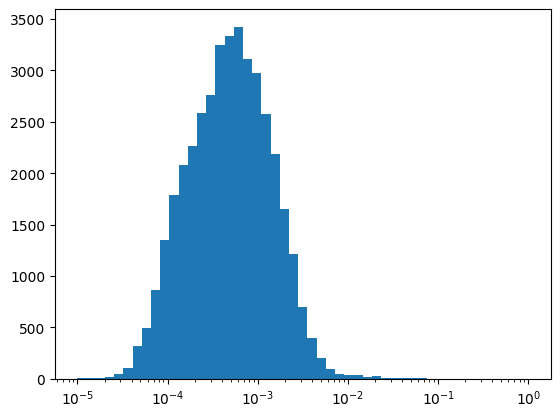

In [37]:
# plot feature_mse with log x bins
import matplotlib.pyplot as plt
import numpy as np

plt.hist(feature_mse.numpy(), bins=np.logspace(-5, 0, 50))
plt.gca().set_xscale("log")
plt.show()

In [16]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        